# Ex2: Byoungsoo Kim

In [1]:
!(@isdefined cleanup_hook) && IJulia.push_postexecute_hook(() -> (empty!(In); empty!(Out); GC.gc(true))); cleanup_hook = true;

In [2]:
using PyCall, PyPlot

In [3]:
@pyimport numpy as np

## Environment - Tree task

In [4]:
# Setting up the environment
# from now on, action = -1: L, = 0: C, = 1: R
function u1(action)
    """
    input
    action: -1, 0, 1

    output
    reward: reward from the action
    next_state: probabilistically determined states at next step
    """
    if action == -1
        reward = 1;
        next_state = 1;
    elseif action == 1
        reward = 2;
        next_state = 1;
    elseif action == 0
        reward = -1;
        next_state = np.random.choice([2,3])
    end

    return reward, next_state
end

function u2(action)
    """
    input
    action: -1,1

    output
    reward: reward from the action
    next_state: probabilistically determined states at next step
    """
    if action == -1
        reward = 8;
        next_state = 2;
    elseif action == 1
        reward = -8;
        next_state = 2;
    end

    return reward, next_state
end

function u3(action)
    """
    input
    action: -1,1

    output
    reward: reward from the action
    next_state: probabilistically determined states at next step
    """
    if action == -1
        reward = 0
        next_state = 3;
    elseif action == 1
        reward = 4
        next_state = 3;
    end

    return reward, next_state
end;

## Policy evaluation

In [5]:
# Implement the policy evaluation learning rule
function action_choice(cur_state)
    """
    input
    cur_state: the current state of the agent

    output
    action: possible action from the current state
    """
    if cur_state == 1
        action = np.random.choice([-1,0,1]) # equiprobable
    else
        action = np.random.choice([-1,1]) # equiprobable
    end

    return action
end

function action_result(cur_state, action)
    """
    input
    cur_state: the current state of the agent
    action: the action that the agent takes at the current state (output of the action_choice)

    output
    r: reward from the action
    next_state: the new state the action takes the agent
    """
    if cur_state == 1
        r, next_state = u1(action);
    elseif cur_state == 2
        r, next_state = u2(action);
    elseif cur_state == 3
        r, next_state = u3(action);
    end

    return r, next_state
end

function prediction(r,v,next_state,cur_state,lr)
    """
    input
    v: a vector of predictions for each state
    cur_state: current state of an agent
    action: action of the agent at current state
    lr: learning rate
    
    output
    v: an updated vector of predictions for each state
    d: prediction error, so called "delta"
    """
    d = r + v[next_state]*(cur_state != next_state) - v[cur_state] # if the current state is the same as the next state, set v(new_state) = 0
    v[cur_state] = v[cur_state] + lr*d

    return v, d
end;

In [6]:
# run the learning
N = 1000 # number of learning
M = 1000 # number of trials in one learning
lr = 0.2 # learning rate
# iteration
v_all = Array{Float32, 3}(undef, 3,N,M) # to save the prediction over trials and learnings
for n in 1:N
    # initialize variables
    v = [0.0,0.0,0.0] # prediction
    cur_state = 1
    i = 1;
    # save the variables
    v_all[:,n,i] = v
    i += 1;
    # trials
    while i <= M
        action = action_choice(cur_state)
        r, next_state = action_result(cur_state,action)
        v, _ = prediction(r,v,next_state,cur_state,lr)
        # save the variables
        v_all[:,n,i] = v
        # if the agent is at the end of the tree, start the next iteration.
        if next_state == cur_state
            i += 1;
            cur_state = 1;
        else
            cur_state = next_state
        end  
    end
end;

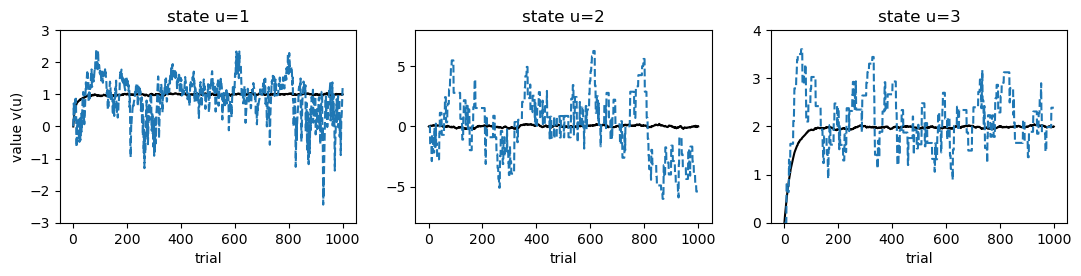

In [7]:
figure(figsize=(13,2.5))
subplot(1,3,1)
plot(1:1000,np.mean(v_all[1,:,:],axis=0)[:],"k")
plot(1:1000,v_all[1,1,:],"--")
ylim(-3,3)
xlabel("trial")
ylabel("value v(u)")
title("state u=1")
subplot(1,3,2)
plot(1:1000,np.mean(v_all[2,:,:],axis=0)[:],"k")
plot(1:1000,v_all[2,1,:],"--")
ylim(-8,8)
xlabel("trial")
title("state u=2")
subplot(1,3,3)
plot(1:1000,np.mean(v_all[3,:,:],axis=0)[:],"k")
plot(1:1000,v_all[3,1,:],"--")
ylim(0,4)
xlabel("trial")
title("state u=3");

## Actor-Critic learning

In [8]:
# Implement the actor-critic learning
# for functions: action_result, prediction, use the ones from the policy evaluation
function softmax(beta,m,cur_state)
    """
    input
    beta: exploration coefficient
    m: action policy
    cur_state: the current state of the agent

    output
    p: calculated possibility of the actions based on softmax function
    """
    p = exp.(beta.*m[cur_state]) ./ sum(exp.(beta.*m[cur_state]))
    
    return p
end

function action_choice(cur_state,m,beta)
    """
    input
    cur_state: the current state of the agent
    m: action policy
    beta: exploration coefficient of the softmax function

    output
    action: the agent's action based on its action policy
    """
    if cur_state == 1
        action = np.random.choice([-1,0,1],p=softmax(beta,m,cur_state)) # not equiprobable, it's based on the policy
    else
        action = np.random.choice([-1,1],p=softmax(beta,m,cur_state)) # not equiprobable, it's based on the policy
    end

    return action
end

function policy_improvement(cur_state,m,action,d,lr_a,lr_d)
    """
    input
    cur_state: the current state of the agent
    m: action policy
    d: prediction error, one of the outputs of the prediction function
    lr_a: actor's learning rate
    lr_d: 1 - self-decaying learning rate of the actor

    output
    m: updated action policy
    """
    
    if cur_state == 1
        m[cur_state][:] .= (1-lr_d).*m[cur_state][:].+lr_a.*([-1,0,1] .== action).*d;
    else
        m[cur_state][:] .= (1-lr_d).*m[cur_state][:].+lr_a.*([-1,1] .== action).*d;
    end

    return m
end;

In [9]:
N = 1000 # number of learning
M = 1000 # trial, number of iteration per learning
lr = 0.2 # learning rate
lr_a = 0.075 # actor's learning rate
lr_d = 0 # 1-self-decaying rate
beta = 1 # softmax beta
# iteration
v_all_ac = Array{Float32, 3}(undef,3,N,M) # to save "v"
m_all_ac = Array{Array}(undef,3,N,M) # to save "m"
for n in 1:N
    # initialize variables
    v = [0.0,0.0,0.0] # prediction
    m = [[0.0,0.0,0.0],[0.0,0.0],[0.0,0.0]] # policy
    cur_state = 1
    i = 1;
    # save the variables
    v_all_ac[:,n,i] = v
    for j in 1:3
        m_all_ac[j,n,i] = copy(m[j])
    end
    i += 1;
    # trials
    while i <= M
        # learning per trial
        action = action_choice(cur_state,m,beta)
        r, next_state = action_result(cur_state,action)
        v,d  = prediction(r,v,next_state,cur_state,lr)
        m = policy_improvement(cur_state,m,action,d,lr_a,lr_d)
        # save the variables
        v_all_ac[:,n,i] = v
        for j in 1:3
            m_all_ac[j,n,i] = copy(m[j])
        end
        # if the agent is at the end of the tree, start the next iteration.
        if next_state == cur_state
            i += 1;
            cur_state = 1;
        else
            cur_state = next_state
        end  
    end
end;

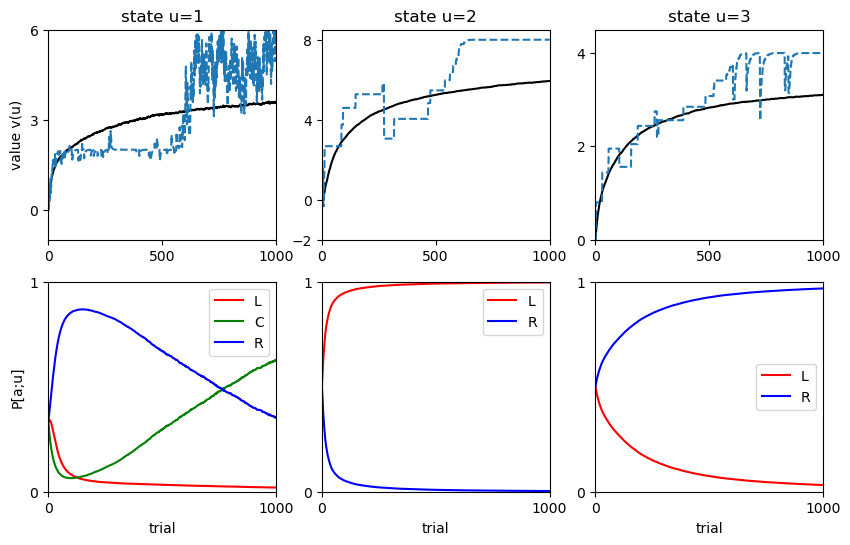

In [10]:
# some calculations for the plot
m1_mean = [np.mean(m_all_ac[1,:,i],axis=0) for i in 1:1000];
m2_mean = [np.mean(m_all_ac[2,:,i],axis=0) for i in 1:1000];
m3_mean = [np.mean(m_all_ac[3,:,i],axis=0) for i in 1:1000];

function softmax_(beta,m)
    return exp.(beta.*m) ./ sum(exp.(beta.*m))
end

p1_mean = softmax_.(1,m1_mean)
p2_mean = softmax_.(1,m2_mean)
p3_mean = softmax_.(1,m3_mean);

figure(figsize=(10,6))
subplot(2,3,1)
plot(1:1000,np.mean(v_all_ac[1,:,:],axis=0)[:],"k")
plot(1:1000,v_all_ac[1,100,:],"--")
xlim(0,1000)
ylim(-1,6)
ylabel("value v(u)")
xticks([0,500,1000])
yticks([0,3,6])
title("state u=1")
subplot(2,3,2)
plot(1:1000,np.mean(v_all_ac[2,:,:],axis=0)[:],"k")
plot(1:1000,v_all_ac[2,100,:],"--")
xlim(0,1000)
ylim(-2,8.5)
title("state u=2")
xticks([0,500,1000])
yticks([-2,0,4,8])
subplot(2,3,3)
plot(1:1000,np.mean(v_all_ac[3,:,:],axis=0)[:],"k")
plot(1:1000,v_all_ac[3,100,:],"--")
xlim(0,1000)
ylim(0,4.5)
title("state u=3")
xticks([0,500,1000])
yticks([0,2,4])

subplot(2,3,4)
plot(1:1000,[p1_mean[i][1] for i in 1:1000],"r",label="L")
plot(1:1000,[p1_mean[i][2] for i in 1:1000],"g",label="C")
plot(1:1000,[p1_mean[i][3] for i in 1:1000],"b",label="R")
legend()
xlim(0,1000)
ylim(0,1)
xticks([0,1000])
yticks([0,1])
xlabel("trial")
ylabel("P[a;u]")
subplot(2,3,5)
plot(1:1000,[p2_mean[i][1] for i in 1:1000],"r",label="L")
plot(1:1000,[p2_mean[i][2] for i in 1:1000],"b",label="R")
legend()
xlim(0,1000)
ylim(0,1)
xticks([0,1000])
yticks([0,1])
xlabel("trial")
subplot(2,3,6)
plot(1:1000,[p3_mean[i][1] for i in 1:1000],"r",label="L")
plot(1:1000,[p3_mean[i][2] for i in 1:1000],"b",label="R")
legend()
xlim(0,1000)
ylim(0,1)
xticks([0,1000])
yticks([0,1])
xlabel("trial");

In [11]:
N = 1000 # number of learning
M = 1000 # trial, number of iteration per learning
lr = 0.2 # learning rate
lr_a = 0.001 # low actor's learning rate
lr_d = 0 # 1-self-decaying rate
beta = 1 # softmax beta
# iteration
v_all_ac = Array{Float32, 3}(undef,3,N,M) # to save "v"
m_all_ac = Array{Array}(undef,3,N,M) # to save "m"
for n in 1:N
    # initialize variables
    v = [0.0,0.0,0.0] # prediction
    m = [[0.0,0.0,0.0],[0.0,0.0],[0.0,0.0]] # policy
    cur_state = 1
    i = 1;
    # save the variables
    v_all_ac[:,n,i] = v
    for j in 1:3
        m_all_ac[j,n,i] = copy(m[j])
    end
    i += 1;
    # trials
    while i <= M
        # learning per trial
        action = action_choice(cur_state,m,beta)
        r, next_state = action_result(cur_state,action)
        v,d  = prediction(r,v,next_state,cur_state,lr)
        m = policy_improvement(cur_state,m,action,d,lr_a,lr_d)
        # save the variables
        v_all_ac[:,n,i] = v
        for j in 1:3
            m_all_ac[j,n,i] = copy(m[j])
        end
        # if the agent is at the end of the tree, start the next iteration.
        if next_state == cur_state
            i += 1;
            cur_state = 1;
        else
            cur_state = next_state
        end  
    end
end;

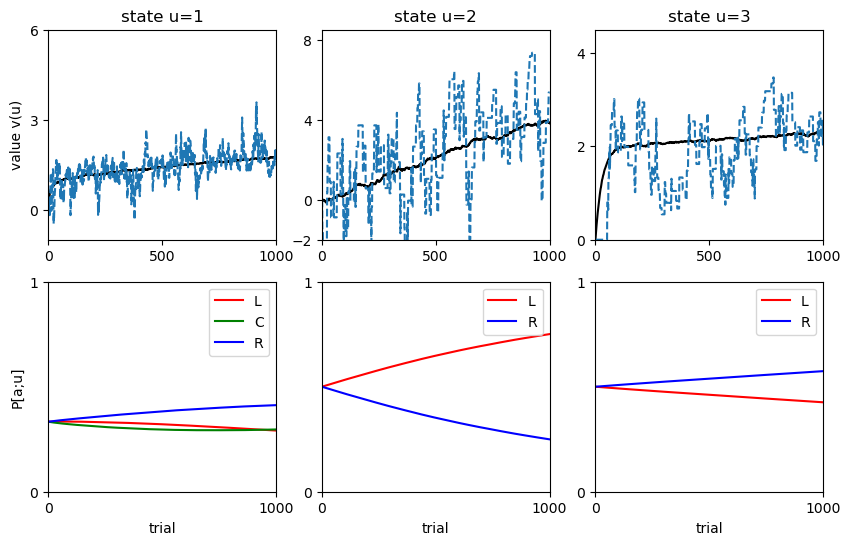

In [12]:
# some calculations for the plot
m1_mean = [np.mean(m_all_ac[1,:,i],axis=0) for i in 1:1000];
m2_mean = [np.mean(m_all_ac[2,:,i],axis=0) for i in 1:1000];
m3_mean = [np.mean(m_all_ac[3,:,i],axis=0) for i in 1:1000];

function softmax_(beta,m)
    return exp.(beta.*m) ./ sum(exp.(beta.*m))
end

p1_mean = softmax_.(1,m1_mean)
p2_mean = softmax_.(1,m2_mean)
p3_mean = softmax_.(1,m3_mean);

figure(figsize=(10,6))
subplot(2,3,1)
plot(1:1000,np.mean(v_all_ac[1,:,:],axis=0)[:],"k")
plot(1:1000,v_all_ac[1,100,:],"--")
xlim(0,1000)
ylim(-1,6)
ylabel("value v(u)")
xticks([0,500,1000])
yticks([0,3,6])
title("state u=1")
subplot(2,3,2)
plot(1:1000,np.mean(v_all_ac[2,:,:],axis=0)[:],"k")
plot(1:1000,v_all_ac[2,100,:],"--")
xlim(0,1000)
ylim(-2,8.5)
title("state u=2")
xticks([0,500,1000])
yticks([-2,0,4,8])
subplot(2,3,3)
plot(1:1000,np.mean(v_all_ac[3,:,:],axis=0)[:],"k")
plot(1:1000,v_all_ac[3,100,:],"--")
xlim(0,1000)
ylim(0,4.5)
title("state u=3")
xticks([0,500,1000])
yticks([0,2,4])

subplot(2,3,4)
plot(1:1000,[p1_mean[i][1] for i in 1:1000],"r",label="L")
plot(1:1000,[p1_mean[i][2] for i in 1:1000],"g",label="C")
plot(1:1000,[p1_mean[i][3] for i in 1:1000],"b",label="R")
legend()
xlim(0,1000)
ylim(0,1)
xticks([0,1000])
yticks([0,1])
xlabel("trial")
ylabel("P[a;u]")
subplot(2,3,5)
plot(1:1000,[p2_mean[i][1] for i in 1:1000],"r",label="L")
plot(1:1000,[p2_mean[i][2] for i in 1:1000],"b",label="R")
legend()
xlim(0,1000)
ylim(0,1)
xticks([0,1000])
yticks([0,1])
xlabel("trial")
subplot(2,3,6)
plot(1:1000,[p3_mean[i][1] for i in 1:1000],"r",label="L")
plot(1:1000,[p3_mean[i][2] for i in 1:1000],"b",label="R")
legend()
xlim(0,1000)
ylim(0,1)
xticks([0,1000])
yticks([0,1])
xlabel("trial");

In [13]:
N = 1000 # number of learning
M = 1000 # trial, number of iteration per learning
lr = 0.8 # learning rate
lr_a = 0.075 # low actor's learning rate
lr_d = 0 # 1-self-decaying rate
beta = 1 # softmax beta
# iteration
v_all_ac = Array{Float32, 3}(undef,3,N,M) # to save "v"
m_all_ac = Array{Array}(undef,3,N,M) # to save "m"
for n in 1:N
    # initialize variables
    v = [0.0,0.0,0.0] # prediction
    m = [[0.0,0.0,0.0],[0.0,0.0],[0.0,0.0]] # policy
    cur_state = 1
    i = 1;
    # save the variables
    v_all_ac[:,n,i] = v
    for j in 1:3
        m_all_ac[j,n,i] = copy(m[j])
    end
    i += 1;
    # trials
    while i <= M
        # learning per trial
        action = action_choice(cur_state,m,beta)
        r, next_state = action_result(cur_state,action)
        v,d  = prediction(r,v,next_state,cur_state,lr)
        m = policy_improvement(cur_state,m,action,d,lr_a,lr_d)
        # save the variables
        v_all_ac[:,n,i] = v
        for j in 1:3
            m_all_ac[j,n,i] = copy(m[j])
        end
        # if the agent is at the end of the tree, start the next iteration.
        if next_state == cur_state
            i += 1;
            cur_state = 1;
        else
            cur_state = next_state
        end  
    end
end;

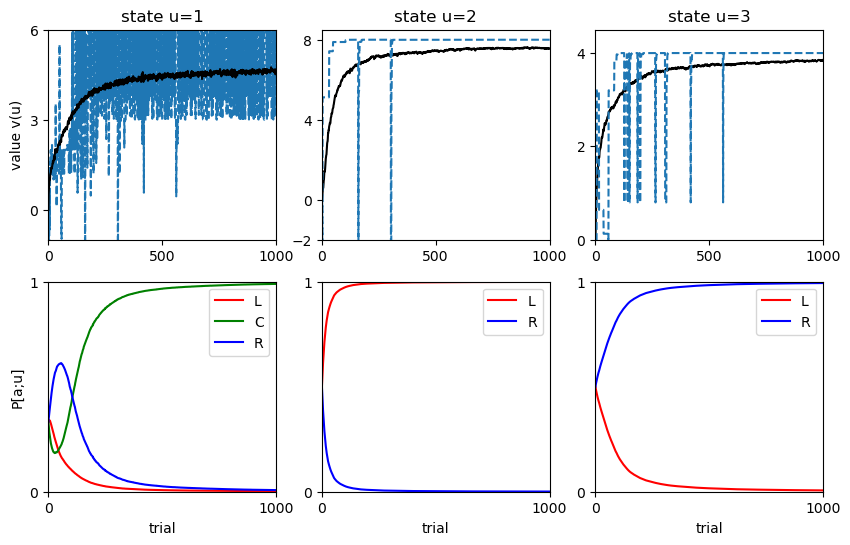

In [14]:
# some calculations for the plot
m1_mean = [np.mean(m_all_ac[1,:,i],axis=0) for i in 1:1000];
m2_mean = [np.mean(m_all_ac[2,:,i],axis=0) for i in 1:1000];
m3_mean = [np.mean(m_all_ac[3,:,i],axis=0) for i in 1:1000];

function softmax_(beta,m)
    return exp.(beta.*m) ./ sum(exp.(beta.*m))
end

p1_mean = softmax_.(1,m1_mean)
p2_mean = softmax_.(1,m2_mean)
p3_mean = softmax_.(1,m3_mean);

figure(figsize=(10,6))
subplot(2,3,1)
plot(1:1000,v_all_ac[1,2,:],"--")
plot(1:1000,np.mean(v_all_ac[1,:,:],axis=0)[:],"k")
# plot(1:1000,v_all_ac[1,2,:],"--")
xlim(0,1000)
ylim(-1,6)
ylabel("value v(u)")
xticks([0,500,1000])
yticks([0,3,6])
title("state u=1")
subplot(2,3,2)
plot(1:1000,np.mean(v_all_ac[2,:,:],axis=0)[:],"k")
plot(1:1000,v_all_ac[2,2,:],"--")
xlim(0,1000)
ylim(-2,8.5)
title("state u=2")
xticks([0,500,1000])
yticks([-2,0,4,8])
subplot(2,3,3)
plot(1:1000,np.mean(v_all_ac[3,:,:],axis=0)[:],"k")
plot(1:1000,v_all_ac[3,2,:],"--")
xlim(0,1000)
ylim(0,4.5)
title("state u=3")
xticks([0,500,1000])
yticks([0,2,4])

subplot(2,3,4)
plot(1:1000,[p1_mean[i][1] for i in 1:1000],"r",label="L")
plot(1:1000,[p1_mean[i][2] for i in 1:1000],"g",label="C")
plot(1:1000,[p1_mean[i][3] for i in 1:1000],"b",label="R")
legend()
xlim(0,1000)
ylim(0,1)
xticks([0,1000])
yticks([0,1])
xlabel("trial")
ylabel("P[a;u]")
subplot(2,3,5)
plot(1:1000,[p2_mean[i][1] for i in 1:1000],"r",label="L")
plot(1:1000,[p2_mean[i][2] for i in 1:1000],"b",label="R")
legend()
xlim(0,1000)
ylim(0,1)
xticks([0,1000])
yticks([0,1])
xlabel("trial")
subplot(2,3,6)
plot(1:1000,[p3_mean[i][1] for i in 1:1000],"r",label="L")
plot(1:1000,[p3_mean[i][2] for i in 1:1000],"b",label="R")
legend()
xlim(0,1000)
ylim(0,1)
xticks([0,1000])
yticks([0,1])
xlabel("trial");

In [15]:
N = 1000 # number of learning
M = 1000 # trial, number of iteration per learning
lr = 0.2 # learning rate
lr_a = 0.075 # low actor's learning rate
lr_d = 0 # 1-self-decaying rate
beta = 10 # softmax beta
# iteration
v_all_ac = Array{Float32, 3}(undef,3,N,M) # to save "v"
m_all_ac = Array{Array}(undef,3,N,M) # to save "m"
for n in 1:N
    # initialize variables
    v = [0.0,0.0,0.0] # prediction
    m = [[0.0,0.0,0.0],[0.0,0.0],[0.0,0.0]] # policy
    cur_state = 1
    i = 1;
    # save the variables
    v_all_ac[:,n,i] = v
    for j in 1:3
        m_all_ac[j,n,i] = copy(m[j])
    end
    i += 1;
    # trials
    while i <= M
        # learning per trial
        action = action_choice(cur_state,m,beta)
        r, next_state = action_result(cur_state,action)
        v,d  = prediction(r,v,next_state,cur_state,lr)
        m = policy_improvement(cur_state,m,action,d,lr_a,lr_d)
        # save the variables
        v_all_ac[:,n,i] = v
        for j in 1:3
            m_all_ac[j,n,i] = copy(m[j])
        end
        # if the agent is at the end of the tree, start the next iteration.
        if next_state == cur_state
            i += 1;
            cur_state = 1;
        else
            cur_state = next_state
        end  
    end
end;

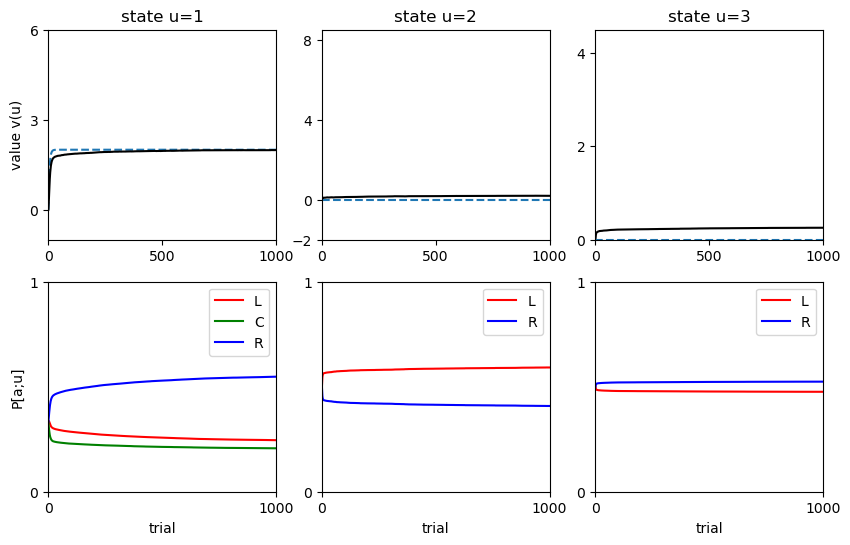

In [16]:
# some calculations for the plot
m1_mean = [np.mean(m_all_ac[1,:,i],axis=0) for i in 1:1000];
m2_mean = [np.mean(m_all_ac[2,:,i],axis=0) for i in 1:1000];
m3_mean = [np.mean(m_all_ac[3,:,i],axis=0) for i in 1:1000];

function softmax_(beta,m)
    return exp.(beta.*m) ./ sum(exp.(beta.*m))
end

p1_mean = softmax_.(1,m1_mean)
p2_mean = softmax_.(1,m2_mean)
p3_mean = softmax_.(1,m3_mean);

figure(figsize=(10,6))
subplot(2,3,1)
plot(1:1000,v_all_ac[1,2,:],"--")
plot(1:1000,np.mean(v_all_ac[1,:,:],axis=0)[:],"k")
# plot(1:1000,v_all_ac[1,2,:],"--")
xlim(0,1000)
ylim(-1,6)
ylabel("value v(u)")
xticks([0,500,1000])
yticks([0,3,6])
title("state u=1")
subplot(2,3,2)
plot(1:1000,np.mean(v_all_ac[2,:,:],axis=0)[:],"k")
plot(1:1000,v_all_ac[2,2,:],"--")
xlim(0,1000)
ylim(-2,8.5)
title("state u=2")
xticks([0,500,1000])
yticks([-2,0,4,8])
subplot(2,3,3)
plot(1:1000,np.mean(v_all_ac[3,:,:],axis=0)[:],"k")
plot(1:1000,v_all_ac[3,2,:],"--")
xlim(0,1000)
ylim(0,4.5)
title("state u=3")
xticks([0,500,1000])
yticks([0,2,4])

subplot(2,3,4)
plot(1:1000,[p1_mean[i][1] for i in 1:1000],"r",label="L")
plot(1:1000,[p1_mean[i][2] for i in 1:1000],"g",label="C")
plot(1:1000,[p1_mean[i][3] for i in 1:1000],"b",label="R")
legend()
xlim(0,1000)
ylim(0,1)
xticks([0,1000])
yticks([0,1])
xlabel("trial")
ylabel("P[a;u]")
subplot(2,3,5)
plot(1:1000,[p2_mean[i][1] for i in 1:1000],"r",label="L")
plot(1:1000,[p2_mean[i][2] for i in 1:1000],"b",label="R")
legend()
xlim(0,1000)
ylim(0,1)
xticks([0,1000])
yticks([0,1])
xlabel("trial")
subplot(2,3,6)
plot(1:1000,[p3_mean[i][1] for i in 1:1000],"r",label="L")
plot(1:1000,[p3_mean[i][2] for i in 1:1000],"b",label="R")
legend()
xlim(0,1000)
ylim(0,1)
xticks([0,1000])
yticks([0,1])
xlabel("trial");

## Environment - Maze task

In [17]:
function junctions(cur_state,action)
    """
    input
    cur_state: current state of the agent
    action: agent's action based on its policy

    output
    reward: reward from the state specific action
    next_state: state that the agent ends up after the action
    """
    if cur_state == 1
        if action == -1
            reward = 0
            next_state = 2
        elseif action == 1
            reward = 0
            next_state = 3
        end
    elseif cur_state == 2
        if action == -1
            reward = 4
            next_state = 2
        elseif action == 1
            reward = 0
            next_state = 2
        end
    elseif cur_state == 3
        if action == -1
            reward = 2
            next_state = 3
        elseif action == 1
            reward = 3
            next_state = 3
        end
    end
    
    return reward, next_state
end;

## Maze task agent

In [18]:
# some new functions matches new environment
function action_choice_maze(cur_state,m,beta)
    """
    input
    cur_state: the current state of the agent
    m: action policy
    beta: exploration coefficient of the softmax function

    output
    action: the agent's action based on its action policy
    """
    action = np.random.choice([-1,1],p=softmax(beta,m,cur_state)) # not equiprobable, it's based on the policy

    return action
end

function action_result_maze(cur_state, action)
    """
    input
    cur_state: the current state of the agent
    action: the action that the agent takes at the current state (output of the action_choice)

    output
    r: reward from the action
    next_state: the new state the action takes the agent
    """
    r, next_state = junctions(cur_state, action)

    return r, next_state
end

function policy_improvement_maze(cur_state,m,action,d,lr_a,lr_d)
    """
    input
    cur_state: the current state of the agent
    m: action policy
    d: prediction error, one of the outputs of the prediction function
    lr_a: actor's learning rate
    lr_d: 1 - self-decaying learning rate of the actor

    output
    m: updated action policy
    """
    m[cur_state][:] .= (1-lr_d).*m[cur_state][:].+lr_a.*([-1,1] .== action).*d;
    
    return m
end;

In [19]:
N = 1000 # number of learning
M = 1000 # trial, number of iteration per learning
lr = 0.2 # learning rate
lr_a = 0.075 # actor's learning rate
lr_d = 0 # 1-self-decaying rate
beta = 1 # softmax beta
# iteration
v_all_maze = Array{Float32, 3}(undef,3,N,M) # to save "v"
m_all_maze = Array{Array}(undef,3,N,M) # to save "m"
for n in 1:N
    # initialize variables
    v = [0.0,0.0,0.0] # prediction
    m = [[0.0,0.0],[0.0,0.0],[0.0,0.0]] # policy
    cur_state = 1
    i = 1;
    # save the variables
    v_all_maze[:,n,i] = v
    for j in 1:3
        m_all_maze[j,n,i] = copy(m[j])
    end
    i += 1;
    # trials
    while i <= M
        # learning per trial
        action = action_choice_maze(cur_state,m,beta)
        r, next_state = action_result_maze(cur_state,action)
        v,d  = prediction(r,v,next_state,cur_state,lr)
        m = policy_improvement_maze(cur_state,m,action,d,lr_a,lr_d)
        # save the variables
        v_all_maze[:,n,i] = v
        for j in 1:3
            m_all_maze[j,n,i] = copy(m[j])
        end
        # if the agent is at the end of the tree, start the next iteration.
        if next_state == cur_state
            i += 1;
            cur_state = 1;
        else
            cur_state = next_state
        end  
    end
end;

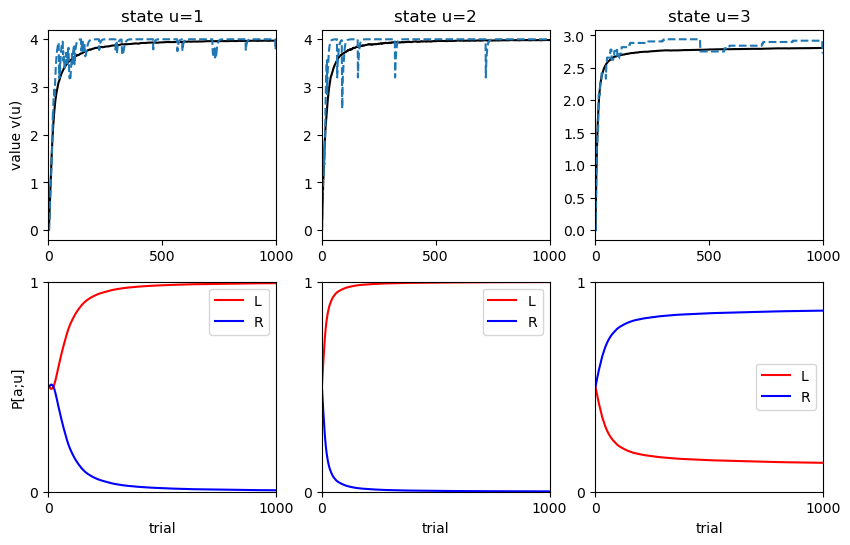

In [20]:
# some calculations for the plot
m1_mean = [np.mean(m_all_maze[1,:,i],axis=0) for i in 1:1000];
m2_mean = [np.mean(m_all_maze[2,:,i],axis=0) for i in 1:1000];
m3_mean = [np.mean(m_all_maze[3,:,i],axis=0) for i in 1:1000];

function softmax_(beta,m)
    return exp.(beta.*m) ./ sum(exp.(beta.*m))
end

p1_mean = softmax_.(1,m1_mean)
p2_mean = softmax_.(1,m2_mean)
p3_mean = softmax_.(1,m3_mean);

figure(figsize=(10,6))
subplot(2,3,1)
plot(1:1000,np.mean(v_all_maze[1,:,:],axis=0)[:],"k")
plot(1:1000,v_all_maze[1,1,:],"--")
xlim(0,1000)
# ylim(0,4)
ylabel("value v(u)")
xticks([0,500,1000])
# yticks([0,3,6])
title("state u=1")
subplot(2,3,2)
plot(1:1000,np.mean(v_all_maze[2,:,:],axis=0)[:],"k")
plot(1:1000,v_all_maze[2,1,:],"--")
xlim(0,1000)
# ylim(0,3)
title("state u=2")
xticks([0,500,1000])
# yticks([-2,0,4,8])
subplot(2,3,3)
plot(1:1000,np.mean(v_all_maze[3,:,:],axis=0)[:],"k")
plot(1:1000,v_all_maze[3,1,:],"--")
xlim(0,1000)
# ylim(0,4)
title("state u=3")
xticks([0,500,1000])
# yticks([0,2,4])

subplot(2,3,4)
plot(1:1000,[p1_mean[i][1] for i in 1:1000],"r",label="L")
plot(1:1000,[p1_mean[i][2] for i in 1:1000],"b",label="R")
legend()
xlim(0,1000)
ylim(0,1)
xticks([0,1000])
yticks([0,1])
xlabel("trial")
ylabel("P[a;u]")
subplot(2,3,5)
plot(1:1000,[p2_mean[i][1] for i in 1:1000],"r",label="L")
plot(1:1000,[p2_mean[i][2] for i in 1:1000],"b",label="R")
legend()
xlim(0,1000)
ylim(0,1)
xticks([0,1000])
yticks([0,1])
xlabel("trial")
subplot(2,3,6)
plot(1:1000,[p3_mean[i][1] for i in 1:1000],"r",label="L")
plot(1:1000,[p3_mean[i][2] for i in 1:1000],"b",label="R")
legend()
xlim(0,1000)
ylim(0,1)
xticks([0,1000])
yticks([0,1])
xlabel("trial");

In [21]:
function junctions(past_states,cur_state,action)
    """
    input
    cur_state: current state of the agent
    action: agent's action based on its policy

    output
    reward: reward from the state specific action
    next_state: state that the agent ends up after the action
    """
    global reward = 0
    if cur_state == 1
        if !(1 in past_states)
            reward = 4
        else
            reward = 0
        end
        if action == 1
            next_state = 2
        elseif action == 2
            next_state = 3
        elseif action == 3
            next_state = 4
        end
    elseif cur_state == 2
        if (1 in past_states)*!(2 in past_states)
            reward = 4
        else
            reward = 0
        end
        if action == 1
            next_state = 3
        elseif action == 2
            next_state = 4
        elseif action == 3
            next_state = 1
        end
    elseif cur_state == 3
        reward = 0
        if action == 1
            next_state = 4
        elseif action == 2
            next_state = 1
        elseif action == 3
            next_state = 2
        end
    elseif cur_state == 4
        reward = 0
        if action == 1
            next_state = 1
        elseif action == 2
            next_state = 2
        elseif action == 3
            next_state = 3
        end
    elseif cur_state == 5
        reward = 0
        if action == 1
            next_state = 1
        elseif action == 2
            next_state = 2
        elseif action == 3
            next_state = 3
        elseif action == 4
            next_state = 4
        end
    end

    append!(past_states,cur_state)
    
    return reward, next_state, past_states
end;

In [22]:
# some new functions matches new environment
function action_choice_plusmaze(cur_state,m,beta)
    """
    input
    cur_state: the current state of the agent
    m: action policy
    beta: exploration coefficient of the softmax function

    output
    action: the agent's action based on its action policy
    """
    if cur_state == 5
        action = np.random.choice([1,2,3,4],p=softmax(beta,m,cur_state)) # not equiprobable, it's based on the policy
    else
        action = np.random.choice([1,2,3],p=softmax(beta,m,cur_state)) # not equiprobable, it's based on the policy
    end
    
    return action
end

function action_result_plusmaze(past_states, cur_state, action)
    """
    input
    past_states: a list of states that the agent visited
    cur_state: the current state of the agent
    action: the action that the agent takes at the current state (output of the action_choice)

    output
    r: reward from the action
    next_state: the new state the action takes the agent
    past_states: updated visited states
    """
    r, next_state, past_states = junctions(past_states, cur_state, action)

    return r, next_state, past_states
end

function policy_improvement_plusmaze(cur_state,m,action,d,lr_a,lr_d)
    """
    input
    cur_state: the current state of the agent
    m: action policy
    d: prediction error, one of the outputs of the prediction function
    lr_a: actor's learning rate
    lr_d: 1 - self-decaying learning rate of the actor

    output
    m: updated action policy
    """
    if cur_state == 5
        m[cur_state][:] .= (1-lr_d).*m[cur_state][:].+lr_a.*([1,2,3,4] .== action).*d;
    else 
        m[cur_state][:] .= (1-lr_d).*m[cur_state][:].+lr_a.*([1,2,3] .== action).*d;
    end
    
    return m
end;

In [23]:
N = 10 # number of learning
M = 1000 # trial, number of iteration per learning
lr = 0.2 # learning rate
lr_a = 0.075 # actor's learning rate
lr_d = 0 # 1-self-decaying rate
beta = 1 # softmax beta
# iteration
v_all_maze = Array{Float32, 3}(undef,5,N,M) # to save "v"
m_all_maze = Array{Array}(undef,5,N,M) # to save "m"
for n in 1:N
    # initialize variables
    v = [0.0,0.0,0.0,0.0,0.0] # prediction
    m = [[0.0,0.0,0.0],[0.0,0.0,0.0],[0.0,0.0,0.0],[0.0,0.0,0.0],[0.0,0.0,0.0,0.0]] # policy
    cur_state = 5 # state 5 is the center of the maze (when the agent is introduced to the chamber)
    past_states = [];
    i = 1;
    # save the variables
    v_all_maze[:,n,i] = v
    for j in 1:5
        m_all_maze[j,n,i] = copy(m[j])
    end
    i += 1;
    # trials
    while i <= M
        # learning per trial
        action = action_choice_plusmaze(cur_state,m,beta)
        r, next_state, past_states = action_result_plusmaze(past_states,cur_state,action)
        v,d  = prediction(r,v,next_state,cur_state,lr)
        m = policy_improvement_plusmaze(cur_state,m,action,d,lr_a,lr_d)
        # save the variables
        v_all_maze[:,n,i] = v
        for j in 1:5
            m_all_maze[j,n,i] = copy(m[j])
        end
        # if the agent is at the end of the tree, start the next iteration.
        if (5 in past_states)*(1 in past_states)*(2 in past_states)*(3 in past_states)*(4 in past_states)
            i += 1;
            cur_state = 5;
        else
            cur_state = next_state
        end  
    end
end;

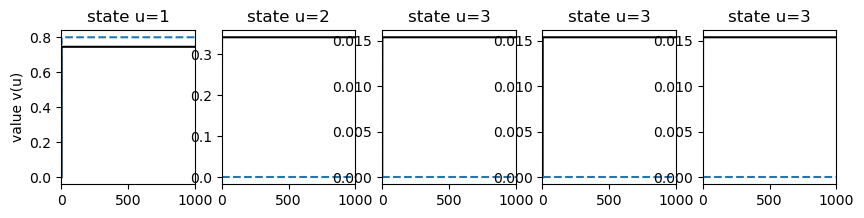

PyObject Text(0.5, 1.0, 'state u=3')

In [24]:
# some calculations for the plot
m1_mean = [np.mean(m_all_maze[1,:,i],axis=0) for i in 1:1000];
m2_mean = [np.mean(m_all_maze[2,:,i],axis=0) for i in 1:1000];
m3_mean = [np.mean(m_all_maze[3,:,i],axis=0) for i in 1:1000];
m4_mean = [np.mean(m_all_maze[4,:,i],axis=0) for i in 1:1000];

function softmax_(beta,m)
    return exp.(beta.*m) ./ sum(exp.(beta.*m))
end

p1_mean = softmax_.(1,m1_mean)
p2_mean = softmax_.(1,m2_mean)
p3_mean = softmax_.(1,m3_mean);
p4_mean = softmax_.(1,m4_mean);

figure(figsize=(10,2))
subplot(1,5,1)
plot(1:1000,np.mean(v_all_maze[1,:,:],axis=0)[:],"k")
plot(1:1000,v_all_maze[1,1,:],"--")
xlim(0,1000)
# ylim(0,4)
ylabel("value v(u)")
xticks([0,500,1000])
# yticks([0,3,6])
title("state u=1")
subplot(1,5,2)
plot(1:1000,np.mean(v_all_maze[2,:,:],axis=0)[:],"k")
plot(1:1000,v_all_maze[2,1,:],"--")
xlim(0,1000)
# ylim(0,3)
title("state u=2")
xticks([0,500,1000])
# yticks([-2,0,4,8])
subplot(1,5,3)
plot(1:1000,np.mean(v_all_maze[3,:,:],axis=0)[:],"k")
plot(1:1000,v_all_maze[3,1,:],"--")
xlim(0,1000)
# ylim(0,4)
title("state u=3")
xticks([0,500,1000])
# yticks([0,2,4])
subplot(1,5,4)
plot(1:1000,np.mean(v_all_maze[3,:,:],axis=0)[:],"k")
plot(1:1000,v_all_maze[3,1,:],"--")
xlim(0,1000)
# ylim(0,4)
title("state u=3")
subplot(1,5,5)
plot(1:1000,np.mean(v_all_maze[3,:,:],axis=0)[:],"k")
plot(1:1000,v_all_maze[3,1,:],"--")
xlim(0,1000)
# ylim(0,4)
title("state u=3")

# subplot(2,3,4)
# plot(1:1000,[p1_mean[i][1] for i in 1:1000],"r",label="L")
# plot(1:1000,[p1_mean[i][2] for i in 1:1000],"b",label="R")
# legend()
# xlim(0,1000)
# ylim(0,1)
# xticks([0,1000])
# yticks([0,1])
# xlabel("trial")
# ylabel("P[a;u]")
# subplot(2,3,5)
# plot(1:1000,[p2_mean[i][1] for i in 1:1000],"r",label="L")
# plot(1:1000,[p2_mean[i][2] for i in 1:1000],"b",label="R")
# legend()
# xlim(0,1000)
# ylim(0,1)
# xticks([0,1000])
# yticks([0,1])
# xlabel("trial")
# subplot(2,3,6)
# plot(1:1000,[p3_mean[i][1] for i in 1:1000],"r",label="L")
# plot(1:1000,[p3_mean[i][2] for i in 1:1000],"b",label="R")
# legend()
# xlim(0,1000)
# ylim(0,1)
# xticks([0,1000])
# yticks([0,1])
# xlabel("trial");